In [1]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.simplefilter('ignore')

import numpy as np
import random
from functools import partial

import torch
import torch.nn as nn

from predictive_model_gpu import make_fc

from greedy_coverage_gpu import set_func, marginal_vec, greedy
from greedy_submodular_gpu import GreedyOptimizer 

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit


Parameters

In [26]:
beta = 1                #Parameter of greedy optimizer
sample_size = 10        #Parameter of greedy optimizer
eps = 0.2               #Parameter of greedy optimizer
k = 10                  #Parameter of greedy optimizer

num_epochs = 10         
batch_size = 200
learning_rate = 1e-3

num_layers = 3
activation = 'relu'
intermediate_size = 200

def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(.0, .01)

In [27]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.cuda.empty_cache()
#Additional Info when using cuda
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.6 GB
Cached:    0.7 GB


In [28]:
N_INFLUENCERS = 100
N_TARGETS = 1000
N_FEATURES = 10
N_INSTANCES = 10 
N_TRAIN = int(0.8 * N_INSTANCES)

##### Instances definition

For each X,Y -> making X_train, X_test, Y_train, Y_test


In [29]:
path = "instances_weibo/"

@jit
def create_train_test(train_id):
    """
    input : train_id, test_id = partition of range(N_INSTANCES)
    returns X_train, Y_train, X_test, Y_test
    """

    X_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    X_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))

    c_train, c_test = 0, 0
    for instance in range(N_INSTANCES) :
        XY = np.load(path + f"{instance}.npz")['arr_0']
        if instance in train_id :
            X_train[c_train] = XY[:,:,:-1]
            Y_train[c_train] = XY[:,:,-1]
            c_train += 1
        else : 
            X_test[c_test] == XY[:,:,:-1]
            Y_test[c_test] == XY[:,:,-1]
            c_test += 1
    
    X_train = torch.from_numpy(X_train).float()
    Y_train = torch.from_numpy(Y_train).float()
    
    X_test = torch.from_numpy(X_test).float()
    Y_test = torch.from_numpy(Y_test).float()
    
    # test on random dense labels 
    # Y_train = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    # Y_test = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    
    
    return X_train, Y_train, X_test, Y_test



In [30]:
%%time
def normalize_train(X) :
    """
    The first 4 features are about influencers, which vary in dimension 1
    The last 4 are about targets, which vary in dimension 2
    
    """ 
    X[:,:,:,:4] = torch.nn.functional.normalize(X[:,:,:,:4], dim=1)
    X[:,:,:,4:] = torch.nn.functional.normalize(X[:,:,:,4:], dim=2)

    return X

w = np.ones(N_TARGETS, dtype=np.float32)
train_id = random.sample(list(range(N_INSTANCES)), N_TRAIN)
X_train, Y_train, X_test, Y_test = create_train_test(train_id)
#X_train = normalize_train(X_train)
dataset = torch.utils.data.TensorDataset(X_train, Y_train) 


Wall time: 2.27 s


### Decision focused

In [31]:
#learning_rate=0.1

train_scores = []
test_scores  = []
loss_f = []
net = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net.apply(init_weights)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

def eval_grd(net, X, Y):
    X = X.to(device)
    Y = Y.to(device)
    return np.mean([set_func(greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1], Y[i, :, :], w) for i in range(X.shape[0])])


epoch | loss | train_score | test_score 
0 | -0.0035378013271838427 | 0.006019964814186096 | 0.0
1 | -0.003891624743118882 | 0.006019964814186096 | 0.0
2 | -0.004462698474526405 | 0.006019964814186096 | 0.0
3 | -0.0038801725022494793 | 0.006019964814186096 | 0.0
4 | -0.0031351165380328894 | 0.006019964814186096 | 0.0
5 | -0.0030341381207108498 | 0.006019964814186096 | 0.0
6 | -0.003655067877843976 | 0.006019964814186096 | 0.0
7 | -0.004501129500567913 | 0.006019964814186096 | 0.0
8 | -0.0033438231330364943 | 0.006019964814186096 | 0.0
9 | -0.003090057522058487 | 0.006019964814186096 | 0.0


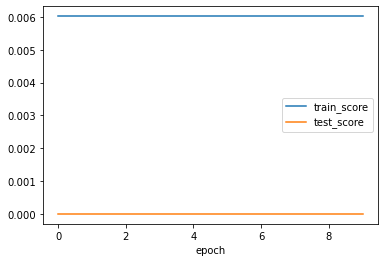

In [32]:

print("epoch | loss | train_score | test_score ")

for epoch in range(num_epochs):

    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X = X.to(device)
            P = P.to(device)
            true_set_func = partial(set_func, P = P, w = w)
            marginal_vec_pred = partial(marginal_vec, w = w)
            pred = net(X).view_as(P)                
            fn = GreedyOptimizer(true_set_func, marginal_vec_pred, n = N_INFLUENCERS, K = k, eps = eps, sample_size = sample_size, beta = beta)
            loss -= fn(pred)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_f.append(loss.item())
    
    train_score = eval_grd(net, X_train, Y_train)
    test_score  = eval_grd(net, X_test, Y_test)

    print(f"{epoch} | {loss} | {train_score} | {test_score}")

    train_scores.append(train_score)
    test_scores.append(test_score)

x = list(range(num_epochs))
sns.lineplot(x, train_scores, label="train_score")
sns.lineplot(x, test_scores, label="test_score")
plt.legend()
plt.xlabel("epoch")
plt.show()


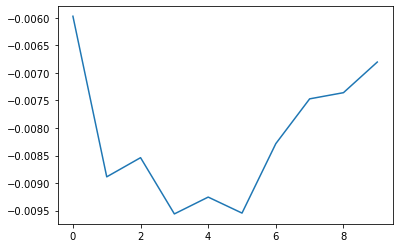

In [17]:
plt.plot([-0.00597064,
-0.00888663996011018,
-0.00853857863694429,
-0.00955985486507415,
-0.00925436336547136,
-0.00954477675259113,
-0.00828347820788621,
-0.00747065478935837,
-0.00735847279429435,
-0.00680229626595974
 ])

The model does not seem to learn anything. The loss does not decrease.

### 2 Stage

epoch | loss | train_score | test_score 
0 | 5.370184953790158e-05 | 0.042716942727565765 | 0.0
1 | 3.664355745058856e-06 | 0.0037878751754760742 | 0.0
2 | 1.7528719808979076e-07 | 0.0037878751754760742 | 0.0
3 | 1.7528718387893605e-07 | 0.0037878751754760742 | 0.0
4 | 1.7528718387893605e-07 | 0.0037878751754760742 | 0.0
5 | 1.7528718387893605e-07 | 0.0037878751754760742 | 0.0
6 | 1.7528718387893605e-07 | 0.0037878751754760742 | 0.0
7 | 1.7528718387893605e-07 | 0.0037878751754760742 | 0.0
8 | 1.7528718387893605e-07 | 0.0037878751754760742 | 0.0
9 | 1.7528718387893605e-07 | 0.0037878751754760742 | 0.0
10 | 1.7528719808979076e-07 | 0.0037878751754760742 | 0.0
11 | 1.7528718387893605e-07 | 0.0037878751754760742 | 0.0
12 | 1.7528718387893605e-07 | 0.0037878751754760742 | 0.0
13 | 1.7528718387893605e-07 | 0.0037878751754760742 | 0.0
14 | 1.7528718387893605e-07 | 0.0037878751754760742 | 0.0


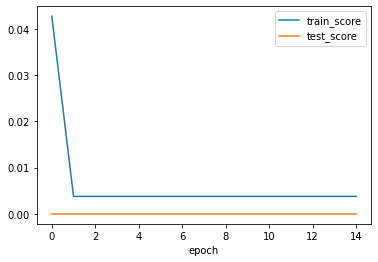

In [45]:

num_epochs = 15
train_scores = []
test_scores  = []
loss_2 = []

net = make_fc(N_FEATURES, num_layers, activation, intermediate_size)
net.apply(init_weights)
net = net.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

print("epoch | loss | train_score | test_score ")

for epoch in range(num_epochs):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X, P = X.to(device), P.to(device)
            pred = net(X).view_as(P)
            loss += loss_fn(pred, P)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_2.append(loss.item())

    
    train_score = eval_grd(net, X_train, Y_train)
    test_score  = eval_grd(net, X_test, Y_test)
    print(f"{epoch} | {loss} | {train_score} | {test_score}")    
    train_scores.append(train_score)
    test_scores.append(test_score)     
    
x = list(range(num_epochs))
sns.lineplot(x, train_scores, label="train_score")
sns.lineplot(x, test_scores, label="test_score")
plt.legend()
plt.xlabel("epoch")
plt.show()


### Random

Average score X_train : 0.08614075250923633
Average score X_test : 0.0


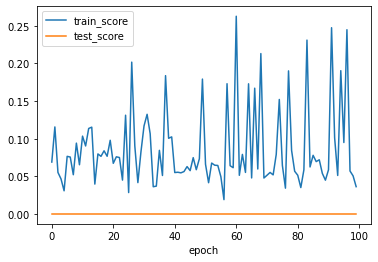

In [53]:

### main ###
train_scores = []
test_scores  = []
    

def eval_rnd(X, Y):
    Y = Y.to(device)
    sol = random.sample(range(N_INFLUENCERS),k)   
    return np.mean([set_func(sol, Y[i,:,:], w) for i in range(X.shape[0])])

for _ in range(100) : 

    train_score = eval_rnd(X_train, Y_train)
    test_score  = eval_rnd(X_test, Y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

print(f"Average score X_train : {np.mean(train_scores)}")
print(f"Average score X_test : {np.mean(test_scores)}")

x = list(range(len(train_scores)))
sns.lineplot(x, train_scores, label="train_score")
sns.lineplot(x, test_scores, label="test_score")
plt.legend()
plt.xlabel("epoch")
plt.show()

